## 數據生成

使用 numpy 隨機生成兩組數據，一組代表紅點，另一組代表綠點，分別分佈在不同的區域（可以根據需求改變點的數量和範圍）。

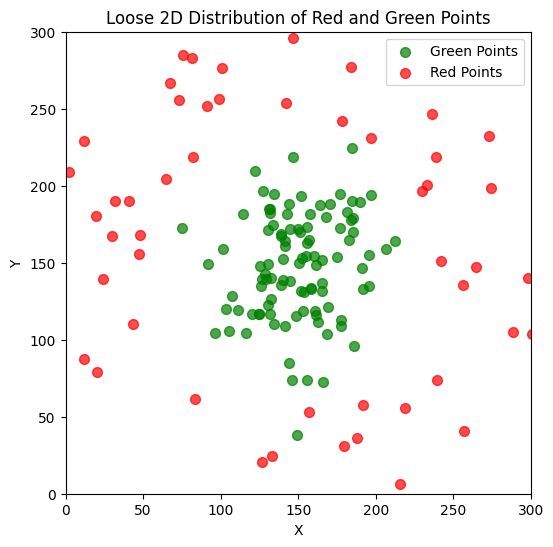

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 設定紅點和綠點的數量
num_green_points = 100
num_red_points = 50

# 生成綠點的隨機分佈，集中在中間，範圍適中 (中心點(150, 150)，半徑範圍擴大)
green_x = np.random.normal(loc=150, scale=30, size=num_green_points)
green_y = np.random.normal(loc=150, scale=30, size=num_green_points)

# 生成紅點的隨機分佈，在綠點的外圍，範圍擴大 (半徑範圍為90至160)
theta = np.random.uniform(0, 2 * np.pi, num_red_points)
radius = np.random.uniform(90, 160, num_red_points)
red_x = 150 + radius * np.cos(theta)  # 將紅點放在以(150, 150)為中心的外圍區域
red_y = 150 + radius * np.sin(theta)

# 繪製圖像
plt.figure(figsize=(6, 6))
plt.scatter(green_x, green_y, c='green', label='Green Points', s=50, alpha=0.7)  # 綠點，分佈鬆散
plt.scatter(red_x, red_y, c='red', label='Red Points', s=50, alpha=0.7)  # 紅點，分佈鬆散

# 添加圖例
plt.legend(loc='upper right')

# 設定軸範圍，確保點的分佈有足夠空間顯示
plt.xlim(0, 300)
plt.ylim(0, 300)

# 添加標籤
plt.xlabel('X')
plt.ylabel('Y')

# 設置標題
plt.title('Loose 2D Distribution of Red and Green Points')

# 保存圖像為PNG文件
plt.savefig('generated_2D_points.png')

# 顯示圖像
plt.show()


## SVM Model

這段代碼使用 SVM 對從圖像中提取的紅色和綠色點進行分類，並可視化了分類結果及其決策邊界。該方法包括圖像處理、數據準備、模型訓練和結果可視化等步驟。

In [12]:
import cv2
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn import svm
from sklearn.model_selection import train_test_split

# 設定圖像路徑
image_path = 'generated_2D_points.png'  # 確認此路徑正確
image = cv2.imread(image_path)

# 檢查圖像是否成功加載
if image is None:
    raise ValueError(f"圖像文件未找到：{image_path}")

# 將圖像從BGR轉換為HSV色彩空間
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 定義紅色和綠色的顏色範圍
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])
lower_green = np.array([40, 40, 40])
upper_green = np.array([70, 255, 255])

# 創建紅色和綠色的掩膜
mask_red = cv2.inRange(image_hsv, lower_red, upper_red)
mask_green = cv2.inRange(image_hsv, lower_green, upper_green)

# 找到紅色和綠色點的輪廓
contours_red, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_green, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 使用輪廓矩來獲取中心點坐標
def get_contour_centers(contours):
    points = []
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            points.append((cX, cY))
    return points

red_points = get_contour_centers(contours_red)
green_points = get_contour_centers(contours_green)

# 創建數據框
data = {
    'x': [x for x, y in red_points + green_points],
    'y': [y for x, y in red_points + green_points],
    'color': ['red'] * len(red_points) + ['green'] * len(green_points)
}

df = pd.DataFrame(data)

# 將顏色轉換為數值標籤
df['label'] = df['color'].apply(lambda x: 1 if x == 'red' else 0)

# 準備數據
X = df[['x', 'y']]
y = df['label']

# 分割數據
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 訓練非線性SVM模型
clf = svm.SVC(kernel='rbf')  # 使用RBF核
clf.fit(X_train, y_train)

# 打印模型得分
print(f"模型準確率: {clf.score(X_test, y_test)}")

# 獲取支持向量和決策邊界
def decision_function(x, y, model):
    xy = np.vstack([x.ravel(), y.ravel()]).T
    z = model.decision_function(xy)
    return z.reshape(x.shape)

# 創建三維數據
X_transformed = np.c_[X.values, clf.decision_function(X)]

# 將數據平移到Z > 0的區域
Z_offset = 10  # 定義平移量
X_transformed[:, 2] += Z_offset

# 創建三維散點圖
fig = go.Figure()

# 繪製紅點和綠點（Z=0平面）
fig.add_trace(go.Scatter3d(x=X['x'], y=X['y'], z=np.zeros_like(X['x']),
                           mode='markers', marker=dict(size=5, color=df['color'].map({'red': 'red', 'green': 'green'}))))

# 繪製平移後的紅點和綠點
fig.add_trace(go.Scatter3d(x=X_transformed[df['label'] == 1, 0], y=X_transformed[df['label'] == 1, 1], z=X_transformed[df['label'] == 1, 2],
                           mode='markers', marker=dict(size=5, color='red')))
fig.add_trace(go.Scatter3d(x=X_transformed[df['label'] == 0, 0], y=X_transformed[df['label'] == 0, 1], z=X_transformed[df['label'] == 0, 2],
                           mode='markers', marker=dict(size=5, color='green')))

# 創建網格來顯示決策邊界
xx, yy = np.meshgrid(np.linspace(X['x'].min(), X['x'].max(), 50),
                     np.linspace(X['y'].min(), X['y'].max(), 50))
zz = decision_function(xx, yy, clf) + Z_offset  # 平移決策邊界

# 繪製分隔平面
fig.add_trace(go.Surface(x=xx, y=yy, z=np.full_like(zz, Z_offset), showscale=False, opacity=0.5, colorscale='Viridis'))

# 設置視角
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Decision Function Value'
))

fig.show()


模型準確率: 0.9444444444444444


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

